<a href="https://colab.research.google.com/github/tangiyooo/yolo_customdata_stop/blob/main/%EC%9A%9C%EB%A1%9C%EB%8D%B0%EC%9D%B4%ED%84%B0_%ED%95%99%EC%8A%B5_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pwd

/content


In [2]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
!git reset --hard 064365d8683fd002e9ad789c1e91fa3d021b44f0

Cloning into 'yolov5'...
remote: Enumerating objects: 16575, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 16575 (delta 28), reused 37 (delta 18), pack-reused 16522
Receiving objects: 100% (16575/16575), 15.09 MiB | 26.23 MiB/s, done.
Resolving deltas: 100% (11381/11381), done.
/content/yolov5
HEAD is now at 064365d8 Update parse_opt() in export.py to work as in train.py (#10789)


In [7]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.downloads import attempt_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 2.2.1+cu121 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15102MB, multi_processor_count=40)


In [10]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="83AvmzBiKZZJ4rJz5avC")
project = rf.workspace("kimyoungjin").project("-stop1")
version = project.version(1)
dataset = version.download("yolov5")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to 캡스톤-stop1-1 in yolov5pytorch:: 100%|██████████| 122/122 [00:00<00:00, 7136.05it/s]


In [11]:
%cd /content/yolov5

/content/yolov5


In [12]:
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
%cat {dataset.location}/data.yaml

names:
- stop
nc: 1
roboflow:
  license: CC BY 4.0
  project: -stop1
  url: https://universe.roboflow.com/kimyoungjin/-stop1/dataset/1
  version: 1
  workspace: kimyoungjin
test: ../test/images
train: "\uCEA1\uC2A4\uD1A4-stop1-1/train/images"
val: "\uCEA1\uC2A4\uD1A4-stop1-1/valid/images"


In [13]:
# define number of classes based on YAML
import yaml
with open(dataset.location + "/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [14]:
#this is the model configuration we will use for our tutorial
%cat /content/yolov5/models/yolov5s.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [15]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [16]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [17]:
# train yolov5s on custom data for 100 epochs
# time its performance
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 100 --data {dataset.location}/data.yaml --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

/content/yolov5
2024-04-29 14:11:04.096168: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-29 14:11:04.096221: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-29 14:11:04.097594: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-29 14:11:05.118998: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
train: weights=, cfg=./models/custom_yolov5s.yaml, data=/content/yolov5/캡스톤-stop1-1/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noa

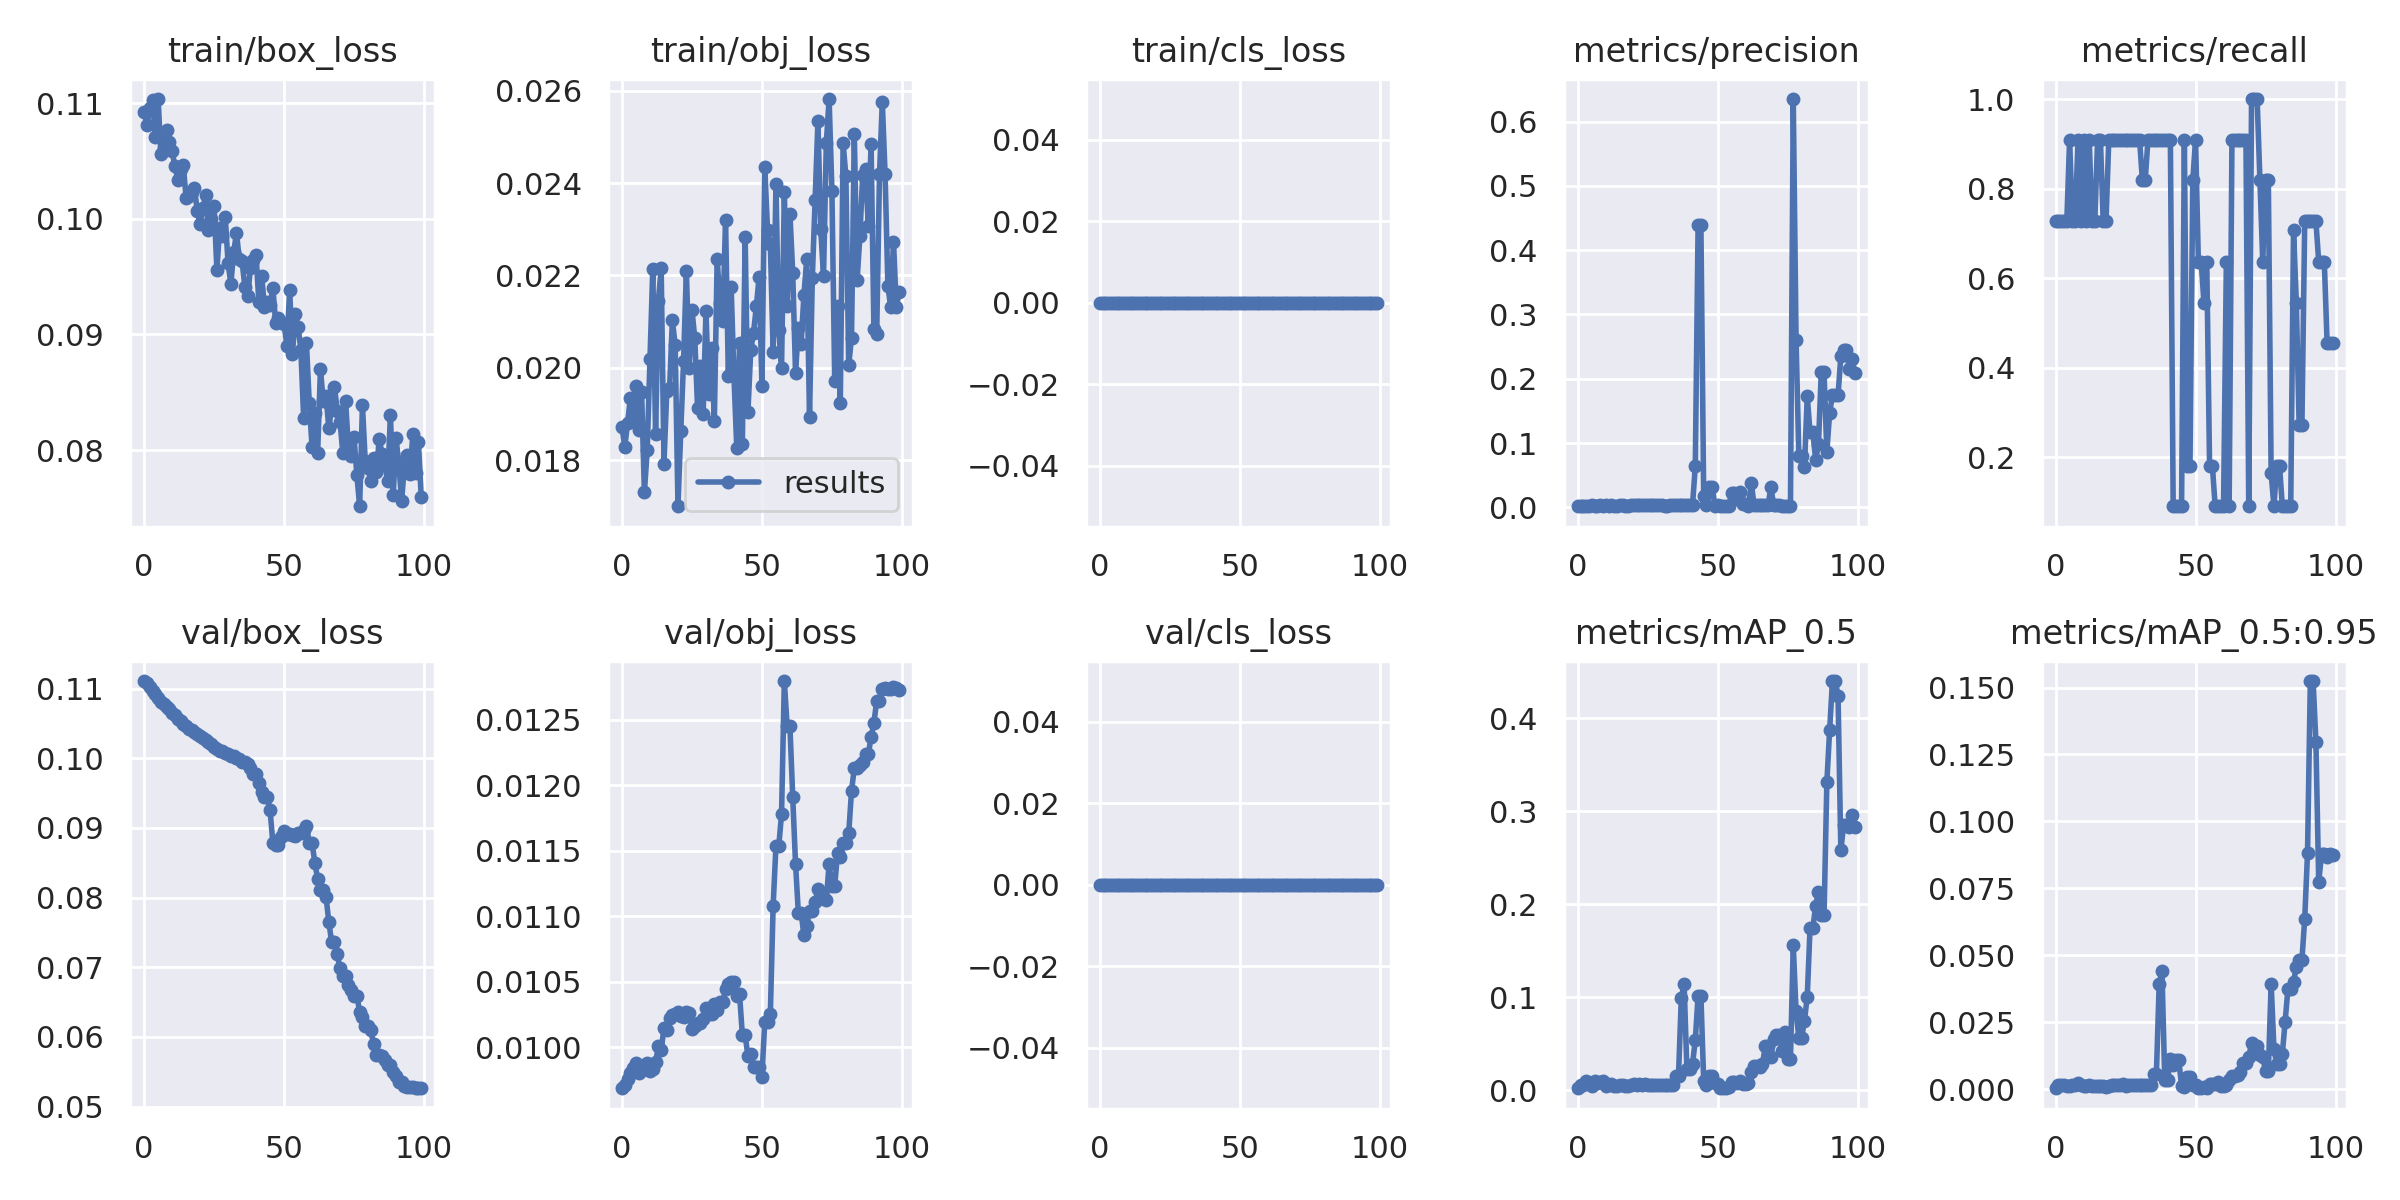

In [18]:
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yolov5s_results/results.png', width=1000)  # view results.png

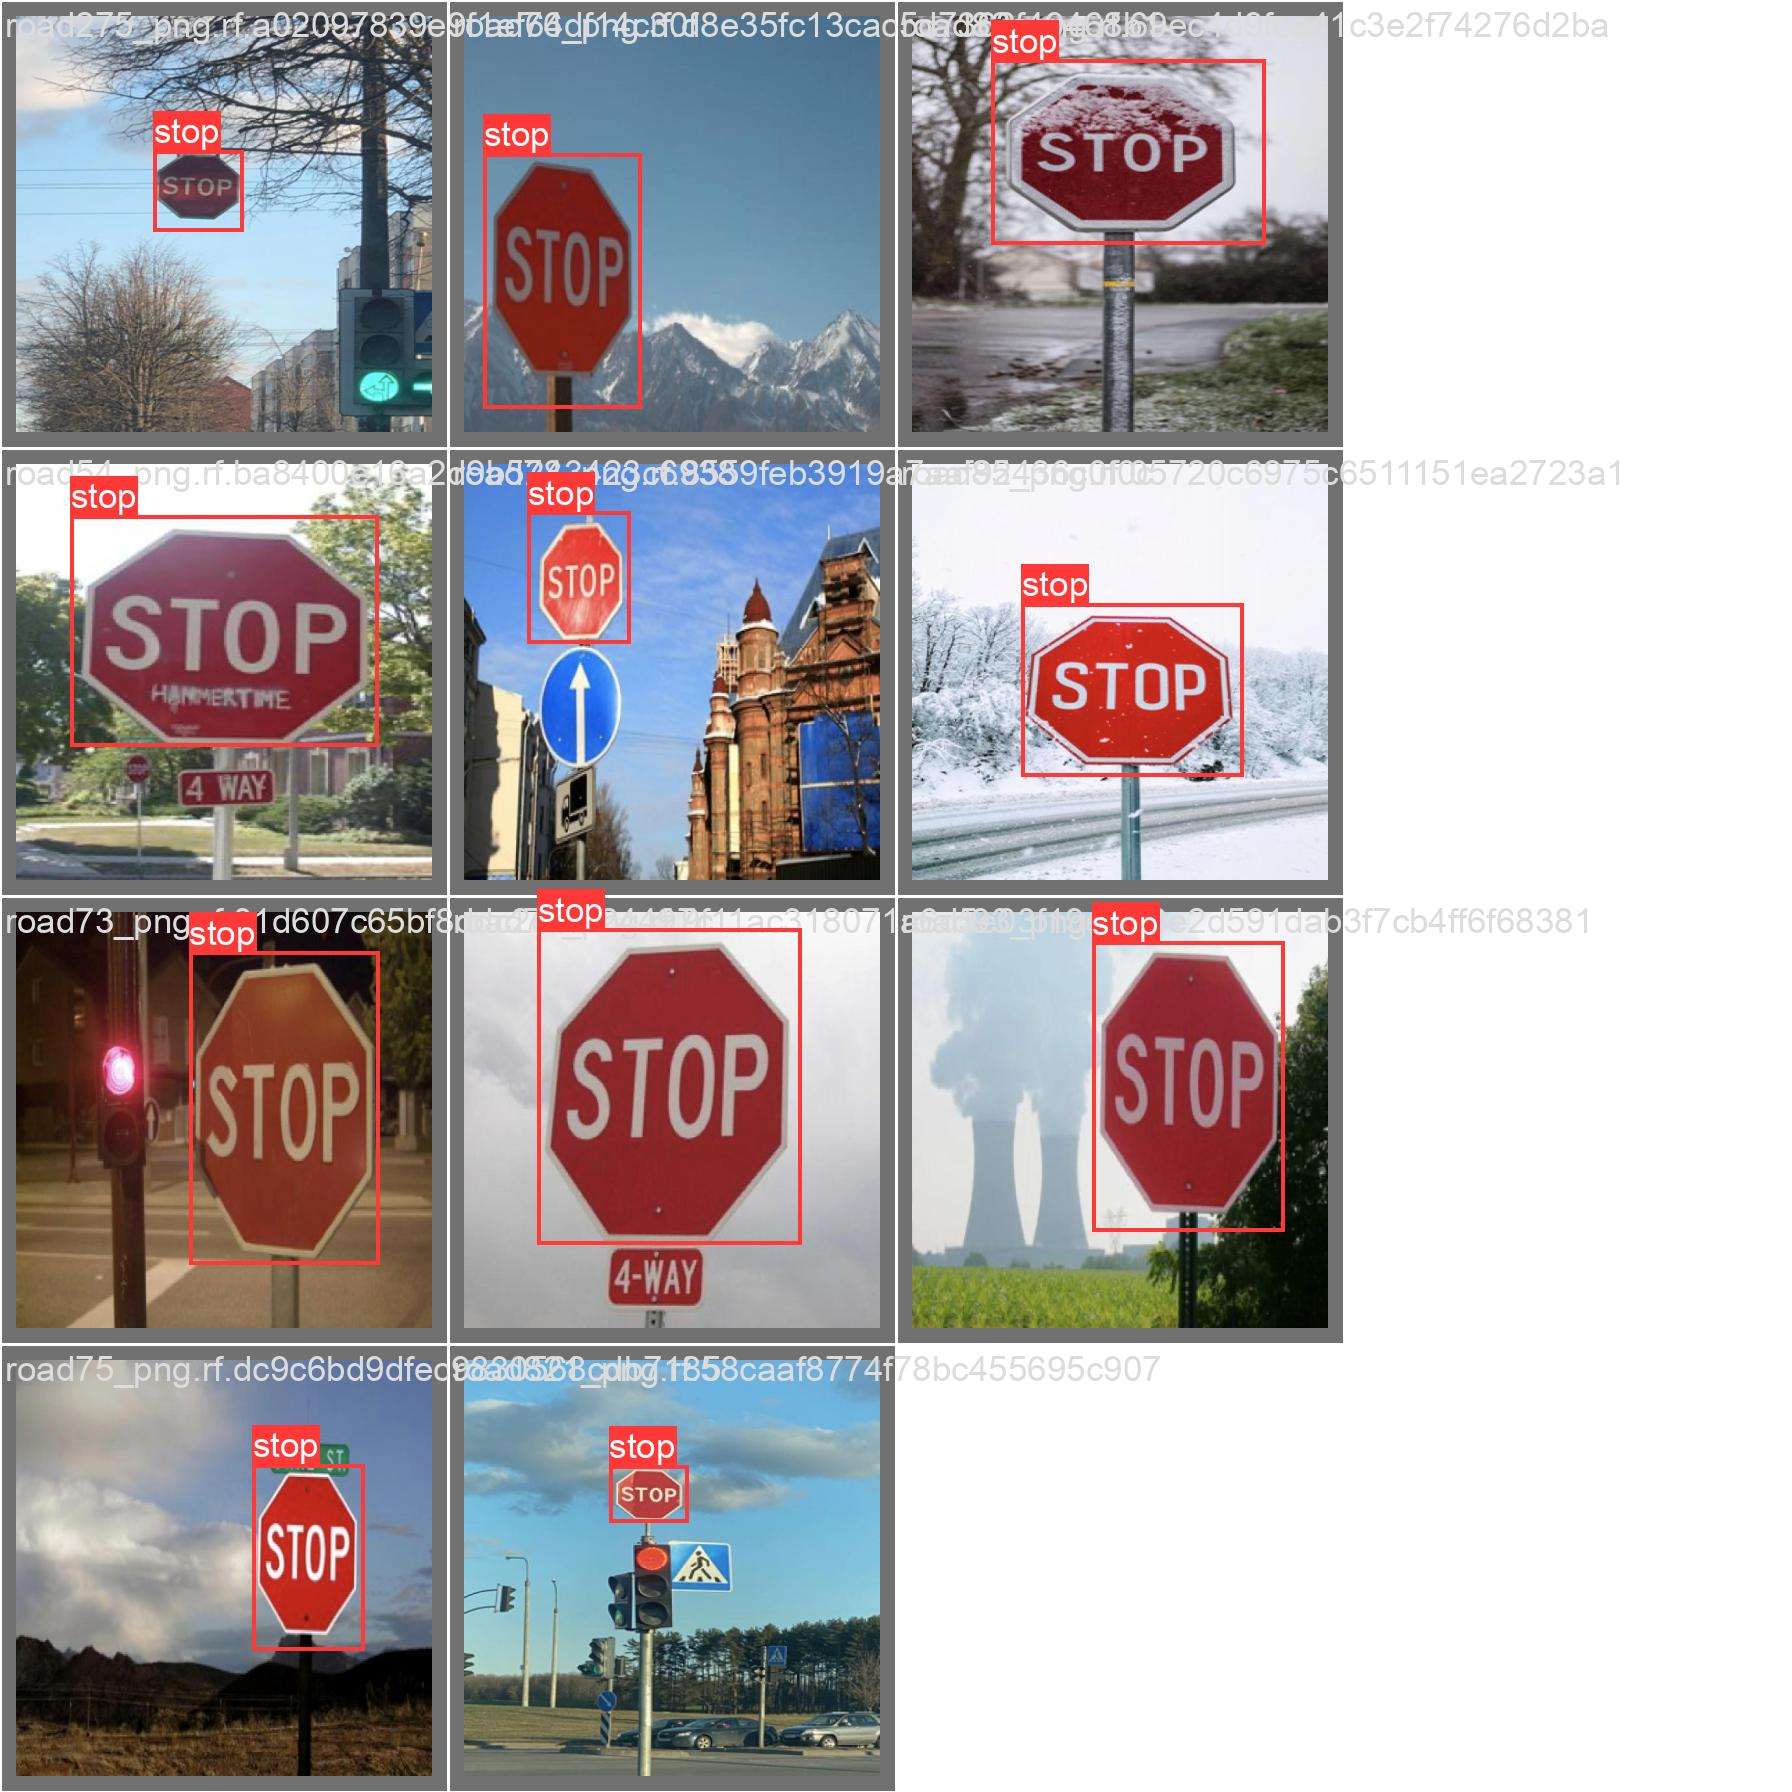

In [19]:
Image(filename='/content/yolov5/runs/train/yolov5s_results/val_batch0_labels.jpg', width=900)

GROUND TRUTH AUGMENTED TRAINING DATA:


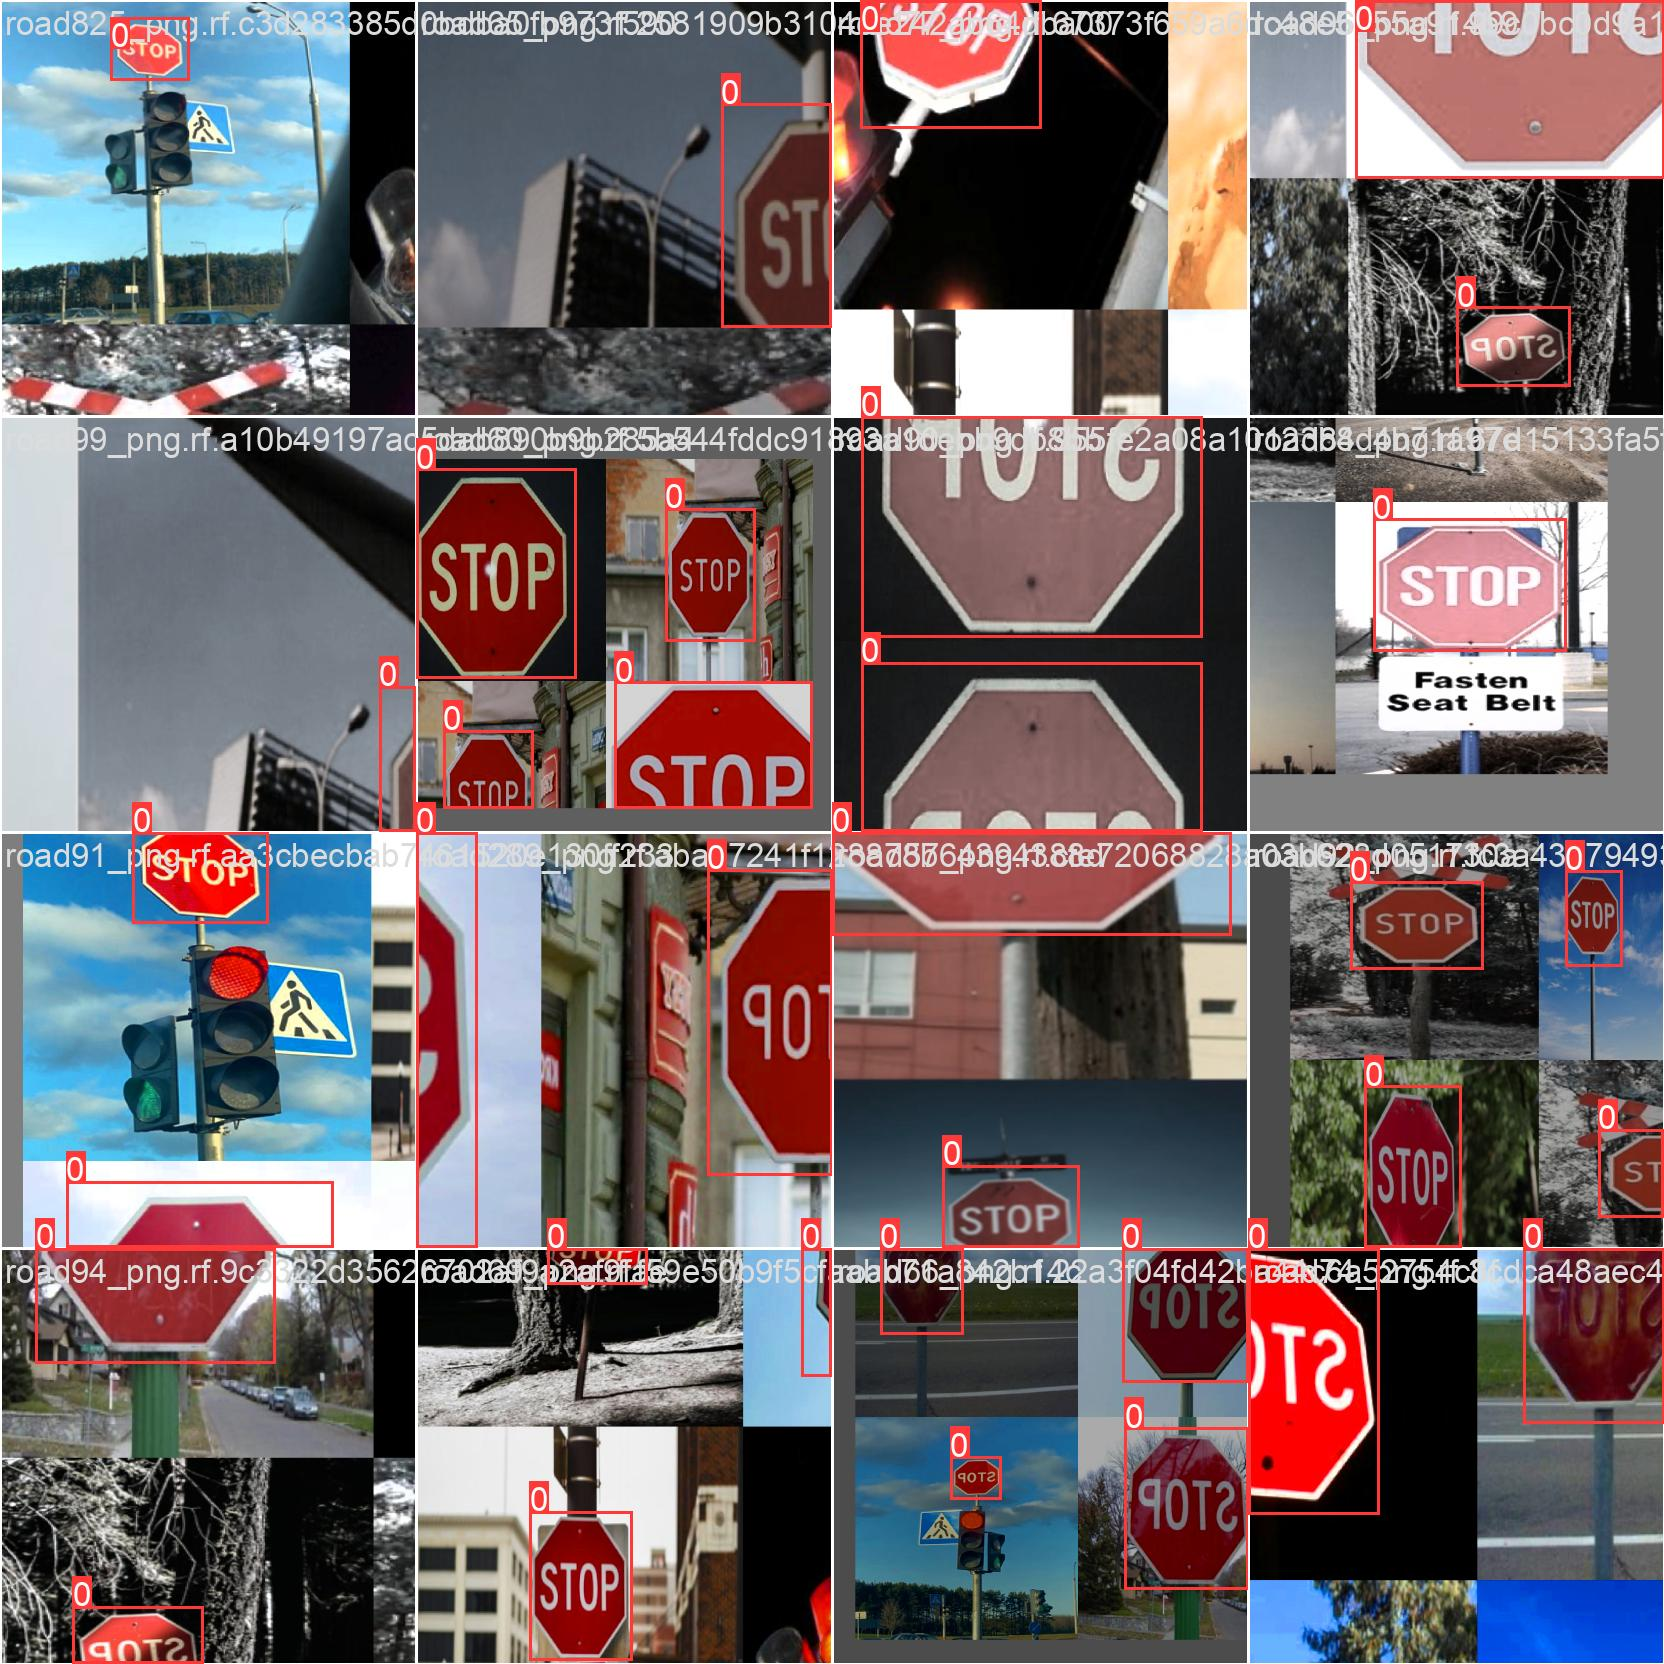

In [20]:
# print out an augmented training example
print("GROUND TRUTH AUGMENTED TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results/train_batch0.jpg', width=900)

In [21]:
# trained weights are saved by default in our weights folder
%ls runs/

train/


In [22]:
%ls runs/train/yolov5s_results/weights

best.pt  last.pt


In [23]:
%cd /content/yolov5/
!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.4 --source Cash-Counter-10/test/images/

/content/yolov5
detect: weights=['runs/train/yolov5s_results/weights/best.pt'], source=Cash-Counter-10/test/images/, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-72-g064365d8 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7246518 parameters, 0 gradients
Traceback (most recent call last):
  File "/content/yolov5/detect.py", line 261, in <module>
    main(opt)
  File "/content/yolov5/detect.py", line 256, in main
    run(**vars(opt))
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/_contextlib.py", line 115, in decorate_context
    return func(*args, **

In [24]:
import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolov5/runs/detect/exp3/*.jpg')[:10]: #assuming JPG
    display(Image(filename=imageName))

In [28]:
rf = Roboflow(api_key="83AvmzBiKZZJ4rJz5avC")
project = rf.workspace("kimyoungjin").project("-stop1")
dataset = project.version(1)

project.version(dataset.version).deploy(model_type="yolov5", model_path=f"/content/yolov5/runs/train/yolov5s_results/")

loading Roboflow workspace...
loading Roboflow project...
View the status of your deployment at: https://app.roboflow.com/kimyoungjin/-stop1/1
Share your model with the world at: https://universe.roboflow.com/kimyoungjin/-stop1/model/1


In [30]:
!docker pull roboflow/roboflow-inference-server-gpu

/bin/bash: line 1: docker: command not found


In [31]:
import requests

workspace_id = ""
model_id = ""
image_url = ""
confidence = 0.75
api_key = ""
iou_threshold = 0.5

infer_payload = {
    "image": {
        "type": "url",
        "value": image_url,
    },
    "confidence": confidence,
    "iou_threshold": iou_threshold,
    "api_key": api_key,
}
res = requests.post(
    f"http://localhost:9001/{workspace_id}/{model_id}",
    json=infer_object_detection_payload,
)

predictions = res.json()

NameError: name 'infer_object_detection_payload' is not defined